Submission - 1 without the macro.csv using linear regression. 

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import preprocessing, model_selection
%matplotlib inline

color = sns.color_palette()
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

train_df = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])
train_df = pd.merge(train_df, macro_df, how = 'left', on = "timestamp")
test_df = pd.merge(test_df, macro_df, how = 'left', on = "timestamp")
print(train_df.shape , test_df.shape)


(30471, 391) (7662, 390)


In [16]:
# truncate the extreme values in price_doc #
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit
print(train_df.shape , test_df.shape)

(30471, 391) (7662, 390)


In [17]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = lbl.transform(list(train_df[f].values.astype('str')))
        test_df[f] = lbl.transform(list(test_df[f].values.astype('str')))

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line

ecology
child_on_acc_pre_school
modern_education_share
old_education_build_share


In [18]:
train_df["null_count"] = train_df.isnull().sum(axis=1)
test_df["null_count"] = test_df.isnull().sum(axis=1)

In [19]:
train_df.fillna(-99, inplace=True)
test_df.fillna(-99, inplace=True)

In [20]:
# year and month #
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month

# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear

# year #
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year

In [ ]:
train_X.head(2)

In [24]:
# implementing xgboost to check importance of each variable
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
test_X = test_df.drop(["id" , "timestamp"], axis =1)


In [25]:
from sklearn.model_selection import train_test_split

t_X, val_X, t_y, val_y = train_test_split(train_X, train_y, test_size=0.30, random_state=42)

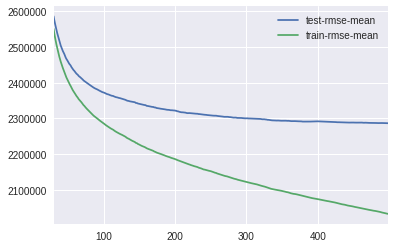

In [26]:
import xgboost as xgb
dtrain = xgb.DMatrix(t_X, label = t_y)
dtest = xgb.DMatrix(val_X)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [10]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(t_X, t_y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [11]:
xgb_preds = model_xgb.predict(val_X)

In [13]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(val_y, xgb_preds))

4.9332986911e+12


In [ ]:
solution = pd.DataFrame({"id":test_df.id, "SalePrice":xgb_preds})
solution.to_csv("pred_sol.csv", index = False)

In [ ]:
solution.head(2)